# Carvana U-Net Angles

## Imports

In [1]:
from keras.layers.advanced_activations import PReLU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from optimizers.AdamAccumulate import AdamAccumulate
from models.u_net import UNet
from models.u_net_aux import UNet_Aux
from models.u_net_heng import UNet_Heng
from utilities.submit import generate_submit
from utilities import utils_masks as utils
from utilities.losses import weighted_bce_dice_loss, dice_value

%load_ext autoreload
%autoreload 2
%matplotlib inline

Using TensorFlow backend.


## Preparing Data

In [2]:
utils.set_results_reproducible()
input_size = 1024
train_path = "inputs/train/{}.jpg" 
train_mask_path = "inputs/train_masks/{}_mask.gif"

df = pd.read_csv('inputs/train_masks.csv')
all_ids = df['img'].map(lambda s: s.split('.')[0])
all_ids_train_split, all_ids_valid_split = train_test_split(all_ids, test_size=0.2, random_state=42)

groups = ['16|01|02','08|09|10','04|05|06','12|13|14','15|03','07|11']
ids_train_splits = {}
ids_valid_splits = {}

for group in groups:
    df_group = df[(df.img.str.match('^.*_(' + group + ').jpg$'))]
    ids_group = df_group['img'].map(lambda s: s.split('.')[0])
    ids_train_split = pd.Series(list(set(all_ids_train_split).intersection(set(ids_group))))
    ids_valid_split = pd.Series(list(set(all_ids_valid_split).intersection(set(ids_group))))
    ids_train_splits[group] = ids_train_split
    ids_valid_splits[group] = ids_valid_split
    print('group {0}:   #Training = {1}   #Validation = {2}'.format(group, len(ids_train_split), len(ids_valid_split)))

#bboxes = None
bbox_file_path = 'inputs/train_bbox.csv'
bboxes = utils.get_bboxes(bbox_file_path)

def train_generator(batch_size, group, outputs=None):
    return utils.train_generator(train_path, train_mask_path, ids_train_splits[group], 
                                 input_size, batch_size, bboxes, outputs=outputs,
                                 augmentations=['HUE_SATURATION', 'SHIFT_SCALE'])

def valid_generator(batch_size, group, outputs=None):
    return utils.valid_generator(train_path, train_mask_path, ids_valid_splits[group],
                                 input_size, batch_size, bboxes, outputs=outputs)

group 16|01|02:   #Training = 758   #Validation = 196
group 08|09|10:   #Training = 758   #Validation = 196
group 04|05|06:   #Training = 762   #Validation = 192
group 12|13|14:   #Training = 765   #Validation = 189
group 15|03:   #Training = 520   #Validation = 116
group 07|11:   #Training = 507   #Validation = 129


## Create Models

In [3]:
#U-Net-Aux:
#model = UNet_Aux((input_size, input_size, 3), filters=64, depth=4, dropout_base_only=False, dropout=0,
#                 activation=lambda x: PReLU()(x), init='he_uniform', auxiliaries=[False, True, True, False])
#outputs = {'aux_out1':2**-1, 'aux_out2':2**-2, 'main_out':1}
#weights = {'aux_out1':0.2, 'aux_out2':0.05, 'main_out':1.}
#model.compile(optimizer=AdamAccumulate(accum_iters=4), 
#              loss=weighted_bce_dice_loss, metrics=[dice_value], loss_weights=weights)

#U-Net:
#model = UNet((input_size, input_size, 3), filters=64, depth=4, dropout_base_only=False, dropout=0,
#             activation=lambda x: PReLU()(x), init='he_uniform')
#model.compile(optimizer=AdamAccumulate(accum_iters=4), loss=weighted_bce_dice_loss, metrics=[dice_value])

models = {}
for group in groups:
    model = UNet_Heng((input_size, input_size, 3))
    models[group] = model

## Fit Models

In [ ]:
epochs = 150
batch_size = 1

for group in groups:
    model = models[group]
    model.compile(optimizer=AdamAccumulate(accum_iters=32),
                  loss=weighted_bce_dice_loss, metrics=[dice_value])
    run_name = utils.get_run_name('weights/{}.hdf5', 'unet-heng-{}'.format(group))
    weights_path = 'weights/{}.hdf5'.format(run_name)

    callbacks = [EarlyStopping(monitor='val_dice_value',
                               patience=8,
                               verbose=1,
                               min_delta=1e-4,
                               mode='max'),
                 ReduceLROnPlateau(monitor='val_dice_value',
                                   factor=0.1,
                                   patience=4,
                                   verbose=1,
                                   epsilon=1e-4,
                                   mode='max'),
                 ModelCheckpoint(monitor='val_dice_value',
                                 filepath=weights_path,
                                 save_best_only=True,
                                 save_weights_only=True,
                                 mode='max'),
                 TensorBoard(log_dir='logs/{}'.format(run_name), batch_size=batch_size)]

    model.load_weights('weights/unet-heng-crop-2017-09-18-1053.hdf5')
    K.set_value(model.optimizer.lr, 1e-4)

    print('Starting run "{}"'.format(run_name))
    model.fit_generator(generator=train_generator(batch_size, group),
                        steps_per_epoch=np.ceil(float(len(ids_train_splits[group])) / float(batch_size)),
                        epochs=epochs,
                        verbose=1,
                        callbacks=callbacks,
                        validation_data=valid_generator(batch_size, group),
                        validation_steps=np.ceil(float(len(ids_valid_splits[group])) / float(batch_size)))

## Mask Prediction

In [5]:
from PIL import Image
import cv2
from glob import glob

In [6]:
model.load_weights('weights/unet-2017-09-02-1809.hdf5')

In [7]:
imgs_names = glob('inputs/train/*.jpg')

In [ ]:
num = 1
input_size = 1024
pred_mask_path = "outputs/pred_train_masks/{}_mask.gif"
for i in range(len(imgs_names)):
    im = cv2.imread(imgs_names[i])
    im = cv2.resize(im, (input_size, input_size), interpolation=cv2.INTER_LINEAR)
    im = np.expand_dims(im, axis=0)
    im = np.array(im, np.float32) / 255
    #print im.shape
    pred_mask = model.predict(im, batch_size=1, verbose=2)
    #print pred_mask.shape
    pred_mask = np.squeeze(pred_mask, axis=[0, 3])
    #print pred_mask.shape
    pred_mask = cv2.resize(pred_mask, (1918, 1280), interpolation=cv2.INTER_LINEAR)
    #print pred_mask.shape
    pred_mask = (pred_mask > 0.95)
    pred_mask = Image.fromarray((pred_mask * 255).astype(np.uint8), mode='L')
    im_name = imgs_names[i].split('/')[-1]
    im_id = im_name.split('.')[0]
    pred_mask.save(pred_mask_path.format(im_id))
    
    if num%500==0:
        print '{0}/{1}'.format(num, len(imgs_names))
    num += 1

500/5088
1000/5088
1500/5088
2000/5088
2500/5088
3000/5088
3500/5088
4000/5088
4500/5088


In [6]:
#val_imgs, _ = next(valid_generator(len(ids_valid_split)))
train_imgs, _ = next(train_generator(len(ids_train_split[4000:])))

In [7]:
#print val_imgs.shape
print train_imgs.shape

(70, 1024, 1024, 3)


In [8]:
#val_pred_masks = model.predict(val_imgs, batch_size=16, verbose=1)
train_pred_masks = model.predict(train_imgs, batch_size=16, verbose=1)

70/70 [==============================] - 9s     


In [9]:
preds = np.squeeze(train_pred_masks, axis=3)
np.shape(preds)

(70, 1024, 1024)

In [10]:
pred_mask_path = "outputs/valid_masks/{}_mask.gif"

In [11]:
for i in range(train_imgs.shape[0]):
    mask = preds[i]
    mask = cv2.resize(mask, (1918, 1280), interpolation=cv2.INTER_LINEAR)
    mask = (mask > 0.95)
    mask = Image.fromarray((mask * 255).astype(np.uint8), mode='L')
    mask.save(pred_mask_path.format(ids_valid_split.values[i]))

## Validation

In [4]:
def np_dice_value(y_true, y_pred):
    smooth = 1.
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

### Prediction

In [6]:
run_name = 'unet-2017-09-03-1739'
model.load_weights('weights/{}.hdf5'.format(run_name))

val_imgs, val_masks = next(valid_generator(len(ids_valid_split)))
val_imgs = np.array(val_imgs)
val_masks = np.array(val_masks)
val_pred_masks = model.predict(val_imgs, batch_size=1)
masks_val_dices = [np_dice_value(mask, pred_mask) for (mask, pred_mask) in zip(val_masks, val_pred_masks)]

### Display the worst predicted mask for validation examples

2faf504842df_09 0.99134050897


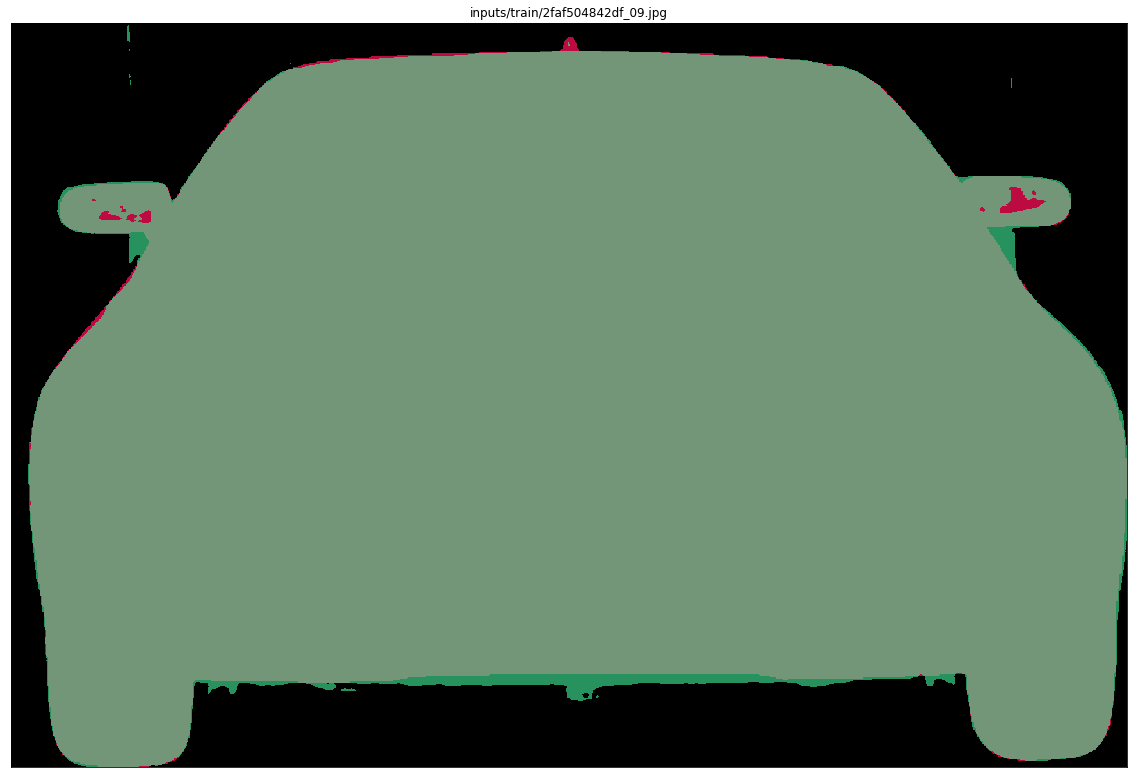

In [20]:
index = np.argsort(masks_val_dices)[7]
id = ids_valid_split.values[index]
utils.show_mask(train_path.format(id), val_masks[index].squeeze(), val_pred_masks[index].squeeze(), show_img=False)
print id, masks_val_dices[index]

In [41]:
indices = np.argsort(masks_val_dices[masks_val_dices <= 99.6])
for id in indices:
        print(masks_val_dices[id])

0.996346765575


### Histogram

In [ ]:
hist, bins = np.histogram(masks_val_dices, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

### Visualization

In [ ]:
indices = np.random.randint(len(ids_valid_split), size=3)
for index in indices:
    id = ids_valid_split.values[index]
    utils.show_mask(train_path.format(id), val_masks[index].squeeze(), val_pred_masks[index].squeeze(),
                    show_img=True, bbox = bboxes[id])

## Test

### Load Model

In [ ]:
# Create model first if required
run_name = 'unet-2017-08-20-5'
model.load_weights('weights/{}.hdf5'.format(run_name))

### Generate Submit

In [ ]:
batch_size = 16
threshold = 0.5
test_path = 'inputs/test1/' #'inputs/test/'
test_masks_path = 'outputs/test1_masks/' #None
generate_submit(model, input_size, batch_size, threshold, test_path, 'outputs/', run_name, test_masks_path)

### Visualization

In [ ]:
utils.show_test_masks(test_path, test_masks_path)